In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

In [ ]:
with open("data_merged.pkl", "rb") as file:
    data_merged = pickle.load(file)

# Convert timestamps
data_merged['timestamp'] = pd.to_datetime(data_merged['timestamp'])
data_merged['signup_date'] = pd.to_datetime(data_merged['signup_date'])

print(f"Data shape: {data_merged.shape}")
print(f"Fraud percentage: {data_merged['is_fraud'].mean()*100:.2f}%")


In [2]:

###################
# 1. TIME SERIES FEATURE ENGINEERING
###################

def create_user_sequence_features(df):
    """
    Create sequence features for each user's transactions,
    respecting chronological order and preventing data leakage
    """
    print("Creating user sequence features...")
    
    # Initialize sequence features
    windows = [3, 5, 7]
    for window in windows:
        df[f'user_amount_mean_{window}'] = np.nan
        df[f'user_amount_std_{window}'] = np.nan
        df[f'user_amount_max_{window}'] = np.nan
        df[f'user_amount_min_{window}'] = np.nan
        df[f'user_txn_count_{window}d'] = np.nan
        df[f'user_hours_since_last_{window}'] = np.nan
        
    # Sort by user and timestamp to maintain chronological order
    df = df.sort_values(['user_id', 'timestamp'])
    
    # Process each user's transactions in sequence
    for user in tqdm(df['user_id'].unique(), desc="Processing user sequences"):
        user_txns = df[df['user_id'] == user].copy()
        
        if len(user_txns) <= 1:
            continue
            
        # Calculate time differences between consecutive transactions (in hours)
        user_txns['hours_since_prev_txn'] = user_txns['timestamp'].diff().dt.total_seconds() / 3600
        
        # For each transaction, compute features based on previous transactions only
        for i in range(1, len(user_txns)):
            curr_idx = user_txns.index[i]
            curr_time = user_txns.iloc[i]['timestamp']
            
            # For each window size
            for window in windows:
                # Get previous window transactions (time-based windows)
                window_start_time = curr_time - pd.Timedelta(days=window)
                prev_txns = user_txns[(user_txns['timestamp'] >= window_start_time) & 
                                      (user_txns['timestamp'] < curr_time)]
                
                # Skip if no previous transactions in window
                if len(prev_txns) == 0:
                    continue
                
                # Amount statistics
                df.loc[curr_idx, f'user_amount_mean_{window}'] = prev_txns['amount'].mean()
                df.loc[curr_idx, f'user_amount_std_{window}'] = prev_txns['amount'].std() if len(prev_txns) > 1 else 0
                df.loc[curr_idx, f'user_amount_max_{window}'] = prev_txns['amount'].max()
                df.loc[curr_idx, f'user_amount_min_{window}'] = prev_txns['amount'].min()
                
                # Transaction count in window
                df.loc[curr_idx, f'user_txn_count_{window}d'] = len(prev_txns)
                
                # Hours since last transaction in window
                last_txn_time = prev_txns['timestamp'].max()
                hours_since_last = (curr_time - last_txn_time).total_seconds() / 3600
                df.loc[curr_idx, f'user_hours_since_last_{window}'] = hours_since_last
        
        # Update hours_since_prev_txn in main dataframe
        df.loc[user_txns.index, 'hours_since_prev_txn'] = user_txns['hours_since_prev_txn']
    
    # Fill remaining NaNs with appropriate values
    for window in windows:
        # Use 0 for standard deviation when there's only one sample
        df[f'user_amount_std_{window}'] = df[f'user_amount_std_{window}'].fillna(0)
        
        # For other metrics, use global medians
        for col in [f'user_amount_mean_{window}', f'user_amount_max_{window}', f'user_amount_min_{window}']:
            df[col] = df[col].fillna(df[col].median())
            
        df[f'user_txn_count_{window}d'] = df[f'user_txn_count_{window}d'].fillna(0)
        df[f'user_hours_since_last_{window}'] = df[f'user_hours_since_last_{window}'].fillna(24*window) # Default to window length
    
    df['hours_since_prev_txn'] = df['hours_since_prev_txn'].fillna(24) # Default to 24 hours for first transaction
    
    return df

def create_merchant_sequence_features(df):
    """
    Create sequence features for each merchant's transactions, 
    tracking fraud patterns over time
    """
    print("Creating merchant sequence features...")
    
    # Initialize new features
    df['merchant_prior_txn_count'] = 0
    df['merchant_prior_fraud_count'] = 0
    df['merchant_prior_fraud_ratio'] = 0
    df['hours_since_last_merchant_txn'] = np.nan
    
    # Process each merchant's transactions in chronological order
    for merchant in tqdm(df['merchant_id'].unique(), desc="Processing merchant sequences"):
        merchant_txns = df[df['merchant_id'] == merchant].sort_values('timestamp')
        
        if len(merchant_txns) <= 1:
            continue
        
        # Track counts as we go
        txn_count = 0
        fraud_count = 0
        last_timestamp = None
        
        # Process each transaction in sequence
        for i in range(len(merchant_txns)):
            current_idx = merchant_txns.index[i]
            current_time = merchant_txns.iloc[i]['timestamp']
            
            # Store current counts (based on prior transactions only)
            df.loc[current_idx, 'merchant_prior_txn_count'] = txn_count
            df.loc[current_idx, 'merchant_prior_fraud_count'] = fraud_count
            df.loc[current_idx, 'merchant_prior_fraud_ratio'] = fraud_count / max(1, txn_count)
            
            # Time since last transaction for this merchant
            if last_timestamp is not None:
                hours_since_last = (current_time - last_timestamp).total_seconds() / 3600
                df.loc[current_idx, 'hours_since_last_merchant_txn'] = hours_since_last
            
            # Update for next transaction
            last_timestamp = current_time
            txn_count += 1
            if merchant_txns.iloc[i]['is_fraud'] == 1:
                fraud_count += 1
    
    # Fill NaN values
    df['hours_since_last_merchant_txn'] = df['hours_since_last_merchant_txn'].fillna(24)  # Default to 24 hours
    
    return df

def create_location_velocity_features(df):
    """
    Create features to detect impossible travel patterns
    by measuring location changes over time
    """
    print("Creating location velocity features...")
    
    # Initialize features
    df['distance_from_prev_txn'] = np.nan
    df['travel_speed_kmh'] = np.nan
    df['impossible_travel'] = 0
    
    # Process each user's transactions
    for user in tqdm(df['user_id'].unique(), desc="Processing location patterns"):
        user_txns = df[df['user_id'] == user].sort_values('timestamp')
        
        if len(user_txns) <= 1:
            continue
        
        # Calculate distances between consecutive transactions
        for i in range(1, len(user_txns)):
            prev_idx = user_txns.index[i-1]
            curr_idx = user_txns.index[i]
            
            # Get coordinates
            lat1, lon1 = user_txns.iloc[i-1]['latitude'], user_txns.iloc[i-1]['longitude']
            lat2, lon2 = user_txns.iloc[i]['latitude'], user_txns.iloc[i]['longitude']
            
            # Calculate approximate distance (in km) using Haversine formula
            # This is a simplified version for speed
            dx = 111.3 * np.cos(np.radians((lat1 + lat2) / 2)) * (lon2 - lon1)
            dy = 111.3 * (lat2 - lat1)
            distance = np.sqrt(dx**2 + dy**2)
            
            # Get time difference in hours
            time_diff = user_txns.iloc[i]['hours_since_prev_txn']
            
            # Calculate travel speed (km/h)
            if time_diff > 0:
                speed = distance / time_diff
            else:
                speed = 0
                
            # Flag impossible travel (threshold set to 900 km/h - faster than commercial flights)
            impossible = 1 if speed > 900 and distance > 100 else 0
            
            # Update features
            df.loc[curr_idx, 'distance_from_prev_txn'] = distance
            df.loc[curr_idx, 'travel_speed_kmh'] = speed
            df.loc[curr_idx, 'impossible_travel'] = impossible
    
    # Fill NaN values
    df['distance_from_prev_txn'] = df['distance_from_prev_txn'].fillna(0)
    df['travel_speed_kmh'] = df['travel_speed_kmh'].fillna(0)
    
    return df

def create_time_based_features(df):
    """
    Create features related to time patterns
    """
    print("Creating time-based features...")
    
    # Basic time features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 5)).astype(int)
    
    # Cyclical encoding for time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    
    # Account age and time since signup
    df['days_since_signup'] = (df['timestamp'] - df['signup_date']).dt.days
    
    # Create hourly risk profile based on historical fraud
    # Group by hour and calculate fraud ratio
    hour_fraud_rate = df.groupby('hour')['is_fraud'].mean().reset_index()
    hour_fraud_dict = dict(zip(hour_fraud_rate['hour'], hour_fraud_rate['is_fraud']))
    
    # Apply hour risk mapping
    df['hour_fraud_risk'] = df['hour'].map(hour_fraud_dict)
    
    return df

def create_behavioral_features(df):
    """
    Create features that detect behavioral anomalies
    """
    print("Creating behavioral anomaly features...")
    
    # Calculate user-level statistics
    user_stats = df.groupby('user_id').agg({
        'amount': ['mean', 'std', 'median', 'max'],
        'channel': lambda x: x.mode()[0] if not x.mode().empty else 'unknown',
        'device': lambda x: x.mode()[0] if not x.mode().empty else 'unknown',
        'payment_method': lambda x: x.mode()[0] if not x.mode().empty else 'unknown',
        'is_international': 'mean'
    })
    
    # Flatten column names
    user_stats.columns = ['_'.join(col).strip('_') for col in user_stats.columns.values]
    
    # Rename for clarity
    user_stats.rename(columns={
        'amount_mean': 'user_avg_amount',
        'amount_std': 'user_std_amount',
        'amount_median': 'user_median_amount',
        'amount_max': 'user_max_amount',
        'channel_<lambda>': 'user_usual_channel',
        'device_<lambda>': 'user_usual_device',
        'payment_method_<lambda>': 'user_usual_payment',
        'is_international_mean': 'user_intl_ratio'
    }, inplace=True)
    
    # Fill NaN values
    user_stats['user_std_amount'] = user_stats['user_std_amount'].fillna(0)
    
    # Merge back to main DataFrame
    df = df.merge(user_stats, left_on='user_id', right_index=True, how='left')
    
    # Create anomaly flags
    df['amount_profile_ratio'] = df['amount'] / df['user_avg_amount'].clip(lower=0.1)
    df['amount_profile_zscore'] = (df['amount'] - df['user_avg_amount']) / df['user_std_amount'].clip(lower=1)
    df['is_unusual_channel'] = (df['channel'] != df['user_usual_channel']).astype(int)
    df['is_unusual_device'] = (df['device'] != df['user_usual_device']).astype(int)
    df['is_unusual_payment'] = (df['payment_method'] != df['user_usual_payment']).astype(int)
    
    # Risk amplifiers
    df['high_amount_for_user'] = (df['amount'] > df['user_max_amount'] * 0.8).astype(int)
    df['intl_unusual_for_user'] = (df['is_international'] > df['user_intl_ratio'] + 0.5).astype(int)
    
    return df

def create_velocity_features(df):
    """
    Create transaction velocity features to detect rapid patterns
    """
    print("Creating transaction velocity features...")
    
    # Sort by timestamp
    df = df.sort_values('timestamp')
    
    # Create initial features
    for window_hours in [6, 24]:
        df[f'txn_count_{window_hours}h'] = 0
        df[f'txn_amount_sum_{window_hours}h'] = 0
    
    # Process each user
    for user in tqdm(df['user_id'].unique(), desc="Processing velocity features"):
        user_txns = df[df['user_id'] == user].sort_values('timestamp')
        
        if len(user_txns) <= 1:
            continue
            
        # For each transaction
        for i in range(len(user_txns)):
            curr_idx = user_txns.index[i]
            curr_time = user_txns.iloc[i]['timestamp']
            
            # For each time window
            for window_hours in [6, 24]:
                # Get window start time
                window_start = curr_time - pd.Timedelta(hours=window_hours)
                
                # Count transactions in window (excluding current)
                prev_txns = user_txns[(user_txns['timestamp'] >= window_start) & 
                                      (user_txns['timestamp'] < curr_time)]
                
                # Update features
                df.loc[curr_idx, f'txn_count_{window_hours}h'] = len(prev_txns)
                df.loc[curr_idx, f'txn_amount_sum_{window_hours}h'] = prev_txns['amount'].sum()
    
    # Calculate velocity ratios
    df['velocity_ratio_24h'] = df['txn_count_24h'] / (df['user_txn_count_7d'].clip(lower=1) / 7 * 24)
    df['amount_velocity_24h'] = df['txn_amount_sum_24h'] / (df['user_avg_amount'].clip(lower=1) * df['txn_count_24h'].clip(lower=1))
    
    # Fill NaNs
    df['velocity_ratio_24h'] = df['velocity_ratio_24h'].fillna(1)
    df['amount_velocity_24h'] = df['amount_velocity_24h'].fillna(1)
    
    return df

def create_composite_risk_scores(df):
    """
    Create composite risk scores combining multiple signals
    """
    print("Creating composite risk scores...")
    
    # Sequence-based amount risk
    df['amount_sequence_risk'] = (
        df['amount_profile_zscore'].clip(-10, 10) * 0.3 +  
        df['high_amount_for_user'] * 3 +
        df['amount_profile_ratio'].clip(0, 10) * 0.2
    )
    
    # Velocity risk
    df['velocity_risk'] = (
        df['velocity_ratio_24h'].clip(0, 10) * 0.5 + 
        df['amount_velocity_24h'].clip(0, 10) * 0.5 +
        (1 / df['hours_since_prev_txn'].clip(0.1, 100))
    )
    
    # Location/device risk
    df['location_device_risk'] = (
        df['impossible_travel'] * 5 +
        df['travel_speed_kmh'].clip(0, 1000) / 200 +
        df['is_unusual_channel'] * 2 +
        df['is_unusual_device'] * 2 +
        df['is_unusual_payment'] * 2 +
        df['is_international'] * 2 +
        df['intl_unusual_for_user'] * 3
    )
    
    # Merchant risk
    df['merchant_risk'] = (
        df['merchant_prior_fraud_ratio'].clip(0, 1) * 10 +
        df['is_first_time_merchant'] * 2
    )
    
    # Time patterns risk
    df['time_pattern_risk'] = (
        df['hour_fraud_risk'] * 5 +
        df['is_night'] * 1.5 +
        df['is_weekend'] * 0.5
    )
    
    # Risk from base features
    df['base_risk'] = (
        df['risk_score'] * 5 +
        df['has_fraud_history'] * 5 +
        df['number_of_alerts_last_6_months'] +
        (10 / (df['account_age_months'] + 1))
    )
    
    # Combined sequence risk score
    df['total_sequence_risk'] = (
        df['amount_sequence_risk'] * 0.25 +
        df['velocity_risk'] * 0.25 +
        df['location_device_risk'] * 0.2 +
        df['merchant_risk'] * 0.15 +
        df['time_pattern_risk'] * 0.05 +
        df['base_risk'] * 0.1
    )
    
    return df

def engineer_time_series_features(df):
    """Apply all time series feature engineering steps"""
    # Convert timestamps
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['signup_date'] = pd.to_datetime(df['signup_date'])
    
    # Sort by timestamp to maintain chronological order
    df = df.sort_values('timestamp')
    
    # Create sequence features
    df = create_user_sequence_features(df)
    df = create_merchant_sequence_features(df)
    df = create_location_velocity_features(df)
    df = create_time_based_features(df)
    df = create_behavioral_features(df)
    df = create_velocity_features(df)
    df = create_composite_risk_scores(df)
    
    # Fill any remaining NaN values
    for col in df.columns:
        if df[col].dtype in [np.float64, np.float32]:
            df[col] = df[col].fillna(0)
        elif df[col].dtype == 'object':
            df[col] = df[col].fillna('Unknown')
    
    return df

In [3]:


###################
# 2. DATA PREPARATION
###################

# Apply feature engineering
print("Applying time series feature engineering...")
data = engineer_time_series_features(data_merged)

# Drop unnecessary columns
drop_cols = ['transaction_id', 'timestamp', 'signup_date', 'user_id', 'merchant_id', 'currency']
X = data.drop(columns=drop_cols + ['is_fraud'])
y = data['is_fraud']

# Encode categorical features
print("Encoding categorical features...")
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].fillna('Unknown'))

print(f"Final feature count: {X.shape[1]}")

# Time-ordered train/val/test split
train_idx = int(0.8 * len(X))
val_idx = int(0.9 * len(X))

X_train = X.iloc[:train_idx]
y_train = y.iloc[:train_idx]

X_val = X.iloc[train_idx:val_idx]
y_val = y.iloc[train_idx:val_idx]

X_test = X.iloc[val_idx:]
y_test = y.iloc[val_idx:]

print(f"Train: {len(X_train)} samples, {y_train.sum()} frauds ({y_train.mean()*100:.2f}%)")
print(f"Val: {len(X_val)} samples, {y_val.sum()} frauds ({y_val.mean()*100:.2f}%)")
print(f"Test: {len(X_test)} samples, {y_test.sum()} frauds ({y_test.mean()*100:.2f}%)")

# Scale numerical features
print("Scaling features...")
numerical_cols = X.select_dtypes(include=['number']).columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])


Applying time series feature engineering...
Creating user sequence features...


Processing user sequences: 100%|██████████| 20000/20000 [25:37<00:00, 13.01it/s]


Creating merchant sequence features...


Processing merchant sequences: 100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


Creating location velocity features...


Processing location patterns: 100%|██████████| 20000/20000 [16:24<00:00, 20.32it/s]


Creating time-based features...
Creating behavioral anomaly features...
Creating transaction velocity features...


Processing velocity features: 100%|██████████| 20000/20000 [19:02<00:00, 17.51it/s]


Creating composite risk scores...
Encoding categorical features...
Final feature count: 91
Train: 400000 samples, 33814 frauds (8.45%)
Val: 50000 samples, 4311 frauds (8.62%)
Test: 50000 samples, 4286 frauds (8.57%)
Scaling features...


In [ ]:
# data.to_csv("data_timeseries_columns.csv", index=False)

In [11]:
# data = pd.read_csv("data_timeseries_columns.csv")
# Za duzy zbior, musialem schunkowac
import os

folder = "timeseries-zbior"
chunk_files = sorted(
    os.path.join(folder, fn)
    for fn in os.listdir(folder)
    if fn.endswith(".csv")
)

data = pd.concat((pd.read_csv(f) for f in chunk_files), ignore_index=True)
data

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,...,txn_amount_sum_24h,velocity_ratio_24h,amount_velocity_24h,amount_sequence_risk,velocity_risk,location_device_risk,merchant_risk,time_pattern_risk,base_risk,total_sequence_risk
0,TX497783,2022-01-01 00:06:00,U04367,M0197,41.78,in-store,EUR,Android,mobile_payment,1,...,0.0,0.0,0.0,0.126701,0.041667,4.000000,0.000000,2.422498,9.607646,1.923981
1,TX466651,2022-01-01 00:12:00,U02226,M0496,160.69,in-store,EUR,Android,bank_transfer,1,...,0.0,0.0,0.0,1.082193,0.041667,4.000000,2.000000,2.422498,10.224709,2.524561
2,TX087684,2022-01-01 00:12:00,U07964,M0056,77.36,online,EUR,Android,debit_card,1,...,0.0,0.0,0.0,0.497248,0.041667,8.000000,0.000000,2.422498,5.131349,2.368988
3,TX005076,2022-01-01 00:13:00,U04685,M0484,45.19,in-store,EUR,Web,debit_card,1,...,0.0,0.0,0.0,0.231917,0.041667,2.000000,2.000000,2.422498,11.964913,2.086012
4,TX429480,2022-01-01 00:14:00,U13341,M0960,10.76,online,EUR,Web,bank_transfer,1,...,0.0,0.0,0.0,-0.137791,0.041667,6.000000,2.000000,2.422498,7.086559,2.305750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,TX090047,2023-12-31 23:51:00,U03235,M0801,25.85,in-store,EUR,Android,credit_card,1,...,0.0,0.0,0.0,0.006016,0.010000,6.006068,2.642202,2.433183,6.387282,2.361935
499996,TX322305,2023-12-31 23:53:00,U11958,M0124,13.04,in-store,EUR,iOS,bank_transfer,0,...,0.0,0.0,0.0,-0.132519,0.010000,6.010105,3.124260,2.433183,11.658604,2.927550
499997,TX112068,2023-12-31 23:54:00,U04945,M0552,17.12,in-store,EUR,Web,bank_transfer,1,...,0.0,0.0,0.0,-0.157754,0.010000,4.074403,2.738523,2.433183,4.816373,1.792017
499998,TX415299,2023-12-31 23:54:00,U05932,M0009,2.98,mobile,EUR,Android,debit_card,1,...,0.0,0.0,0.0,-0.334203,0.010000,6.019049,2.689655,2.433183,5.689877,2.216854


In [3]:
# Perform the splits once again

# Drop unnecessary columns
drop_cols = ['transaction_id', 'timestamp', 'signup_date', 'user_id', 'merchant_id', 'currency']
X = data.drop(columns=drop_cols + ['is_fraud'])
y = data['is_fraud']

# Encode categorical features
print("Encoding categorical features...")
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].fillna('Unknown'))

print(f"Final feature count: {X.shape[1]}")

# Time-ordered train/val/test split
train_idx = int(0.8 * len(X))
val_idx = int(0.9 * len(X))

X_train = X.iloc[:train_idx]
y_train = y.iloc[:train_idx]

X_val = X.iloc[train_idx:val_idx]
y_val = y.iloc[train_idx:val_idx]

X_test = X.iloc[val_idx:]
y_test = y.iloc[val_idx:]

print(f"Train: {len(X_train)} samples, {y_train.sum()} frauds ({y_train.mean()*100:.2f}%)")
print(f"Val: {len(X_val)} samples, {y_val.sum()} frauds ({y_val.mean()*100:.2f}%)")
print(f"Test: {len(X_test)} samples, {y_test.sum()} frauds ({y_test.mean()*100:.2f}%)")

# Scale numerical features
print("Scaling features...")
numerical_cols = X.select_dtypes(include=['number']).columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

Encoding categorical features...
Final feature count: 91
Train: 400000 samples, 33814 frauds (8.45%)
Val: 50000 samples, 4311 frauds (8.62%)
Test: 50000 samples, 4286 frauds (8.57%)
Scaling features...


# Our xgboost

In [4]:
count_majority = (y_train == 0).sum()
count_minority = (y_train == 1).sum()
calculated_scale_pos_weight = float(count_majority) / float(count_minority) if count_minority > 0 else 1.0
calculated_scale_pos_weight

10.82941976696043

In [ ]:
# 2. XGBoost 
import optuna
from sklearn.model_selection import StratifiedKFold
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import ADASYN
# from imblearn.over_sampling import SMOTE

def create_xgb_model(params, scale_pos_weight_value=1.0):
    return xgb.XGBClassifier(
        tree_method='hist',  
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight_value, # Key parameter for imbalance
        early_stopping_rounds=50,  # Adjust as needed
        **params
    )

def objective(trial):
    # Calculate scale_pos_weight based on the original y_train's class distribution
    # This ensures it's calculated on the data before any SMOTE within CV folds
    # (Assumes y_train is accessible in this scope, from your initial data split)
    count_majority = (y_train == 0).sum()
    count_minority = (y_train == 1).sum()
    calculated_scale_pos_weight = float(count_majority) / float(count_minority) if count_minority > 0 else 1.0

    params = {
        'objective': 'binary:logistic', # Explicitly for binary classification
        'eval_metric': 'logloss',       # XGBoost internal metric
        'max_depth': trial.suggest_int('max_depth', 3, 6), # More restrictive
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True), # Lower, log scale
        'n_estimators': trial.suggest_int('n_estimators', 300, 2000),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 10), # Higher for regularization
        'subsample': trial.suggest_float('subsample', 0.5, 0.9), # For stochasticity
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.8), # Feature sampling
        'gamma': trial.suggest_float('gamma', 0.5, 10.0, log=True), # For pruning
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True), # L1 regularization
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True)  # L2 regularization
    }
    
    model = create_xgb_model(params, scale_pos_weight_value=calculated_scale_pos_weight)
    
    # Use fewer splits for faster Optuna iterations if needed, e.g., 3
    # Use trial.number to ensure different random shuffles if shuffle=True
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=trial.number) 
    
    fold_f1_scores_minority = []
    
    for train_idx, val_idx in cv.split(X_train_scaled, y_train): # Split the original X_train, y_train
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # resampler = ADASYN(random_state=42, 
        #         #    n_neighbors=trial.suggest_int('adasyn_n_neighbors', 3, 10),
        #         #    sampling_strategy=trial.suggest_float('adasyn_sampling_strategy', 0.3, 1.0)
        #           )
        # downsampler = RandomUnderSampler(sampling_strategy=1, random_state=42)

        # X_fold_train_resampled, y_fold_train_resampled = downsampler.fit_resample(X_fold_train, y_fold_train)
        # # Apply SMOTE ONLY to the current training fold
        # smote_cv = SMOTE(random_state=42, k_neighbors=5) # k_neighbors can be tuned
        
        # X_fold_train_resampled, y_fold_train_resampled = smote_cv.fit_resample(X_fold_train, y_fold_train)

        model.fit(
            X_fold_train, 
            y_fold_train,
            eval_set=[(X_fold_val, y_fold_val)],  # Evaluate on original validation data
            verbose=False
        )
        
        y_pred_val = model.predict(X_fold_val)
        # Focus on F1 score for the positive (fraud) class (assuming 1 is fraud)
        # zero_division=0.0 handles cases where no positive predictions are made (important for minority class)
        score = f1_score(y_fold_val, y_pred_val, pos_label=1, average='binary', zero_division=0.0)
        fold_f1_scores_minority.append(score)
    
    return np.mean(fold_f1_scores_minority)

# Run Optuna study
# Reduce n_trials for faster initial testing (e.g., 20-30), then increase (e.g., 50-100)
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30)

# Get best parameters
best_optuna_params = study.best_params
print("Best parameters from Optuna:", best_optuna_params)

[I 2025-05-16 10:12:28,117] A new study created in memory with name: no-name-37ea8315-06a3-48d5-b9c2-339a85790482
[I 2025-05-16 10:13:31,483] Trial 0 finished with value: 0.1725252098501028 and parameters: {'max_depth': 3, 'learning_rate': 0.009334634225609418, 'n_estimators': 1470, 'min_child_weight': 2, 'subsample': 0.6443734922458425, 'colsample_bytree': 0.7185383239417037, 'gamma': 3.45691588356695, 'alpha': 0.1575195640134284, 'lambda': 0.0074991186867211955}. Best is trial 0 with value: 0.1725252098501028.
[I 2025-05-16 10:14:26,375] Trial 1 finished with value: 0.16939262051298234 and parameters: {'max_depth': 5, 'learning_rate': 0.016372575742980438, 'n_estimators': 751, 'min_child_weight': 4, 'subsample': 0.5361990511540196, 'colsample_bytree': 0.44354198755982055, 'gamma': 0.601535890982463, 'alpha': 0.006025164205357155, 'lambda': 0.015710255947338842}. Best is trial 0 with value: 0.1725252098501028.
[W 2025-05-16 10:15:10,868] Trial 2 failed with parameters: {'max_depth': 6

KeyboardInterrupt: 

Final scale_pos_weight for training: 10.83


--- Evaluation on Test Set ---
Test F1 Score (Fraud Class, pos_label=1): 0.1737
Test F1 Score (Weighted): 0.6451

Classification Report on Test Set:
               precision    recall  f1-score   support

Not Fraud (0)       0.93      0.55      0.69     45714
    Fraud (1)       0.10      0.55      0.17      4286

     accuracy                           0.55     50000
    macro avg       0.52      0.55      0.43     50000
 weighted avg       0.86      0.55      0.65     50000



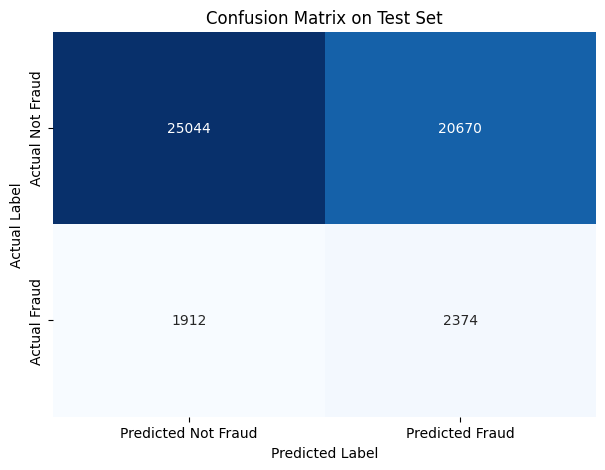


Top 20 Feature Importances:
                           feature  importance
15               has_fraud_history    0.113927
89                       base_risk    0.028312
11                     trust_score    0.027650
4                 is_international    0.021943
23                      risk_score    0.019363
45      merchant_prior_fraud_ratio    0.015409
34               user_txn_count_5d    0.015387
90             total_sequence_risk    0.013596
41         user_hours_since_last_7    0.012033
12  number_of_alerts_last_6_months    0.011987
68               user_usual_device    0.011685
50                            hour    0.011584
56                        hour_cos    0.011439
35         user_hours_since_last_5    0.011375
26               user_amount_max_3    0.011351
58                         day_cos    0.011348
71            amount_profile_ratio    0.011113
32               user_amount_max_5    0.011084
9                         category    0.011073
44      merchant_prior_fraud_co

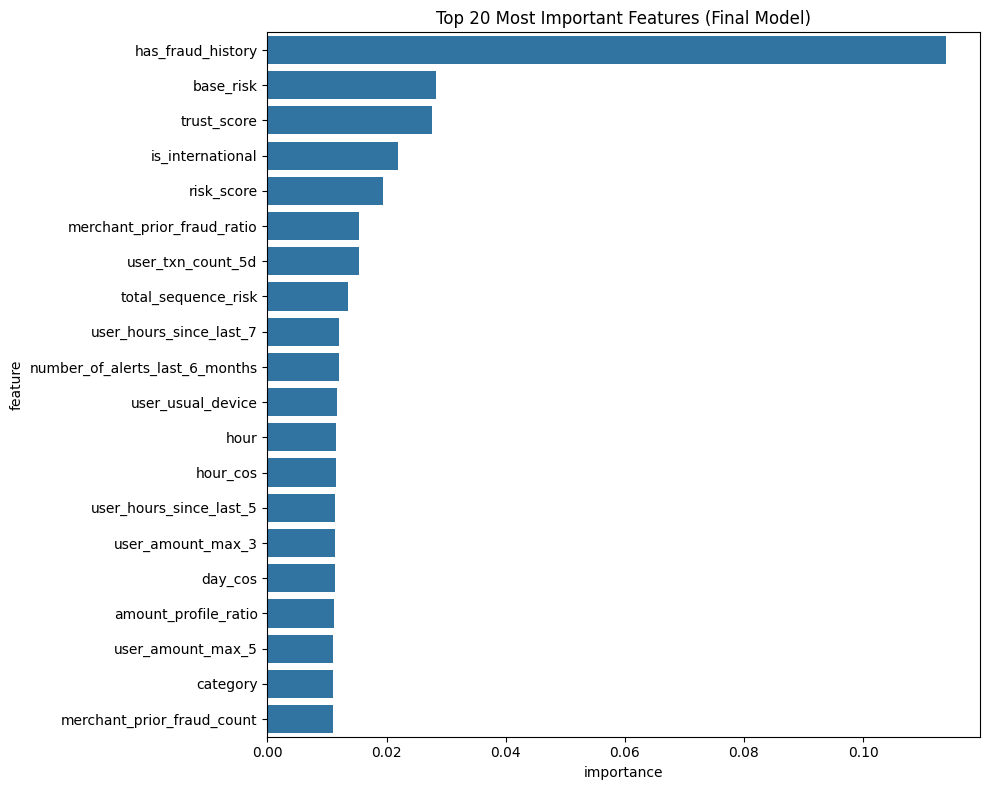

In [9]:
best_optuna_params = {'max_depth': 3, 'learning_rate': 0.019041068548178657, 'n_estimators': 594, 'min_child_weight': 10, 'subsample': 0.5293164806684075, 'colsample_bytree': 0.6807373647413536, 'gamma': 2.877404508422933, 'alpha': 0.0015594348918447007, 'lambda': 0.016863109673092458}

def create_xgb_model(params, scale_pos_weight_value=1.0):
    return xgb.XGBClassifier(
        tree_method='hist',  
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight_value, # Key parameter for imbalance
        **params
    )

# Calculate scale_pos_weight for the FINAL model using the full original y_train
final_count_majority = (y_train == 0).sum()
final_count_minority = (y_train == 1).sum()
final_scale_pos_weight = float(final_count_majority) / float(final_count_minority) if final_count_minority > 0 else 1.0
print(f"Final scale_pos_weight for training: {final_scale_pos_weight:.2f}" + "\n")

# # Apply SMOTE to the full training set (X_train, y_train) before final training
# smote_final = SMOTE(random_state=42, k_neighbors=5) # Adjust k_neighbors if needed

# X_train_final_resampled, y_train_final_resampled = smote_final.fit_resample(X_train, y_train)

# Create and Train the final model
final_model = create_xgb_model(best_optuna_params, scale_pos_weight_value=final_scale_pos_weight)

final_model.fit(X_train_scaled, y_train)


# Evaluate on the original (non-resampled) X_test
y_pred_test = final_model.predict(X_test_scaled)
y_pred_proba_test = final_model.predict_proba(X_test_scaled)[:, 1] # Probabilities for fraud class

print("\n--- Evaluation on Test Set ---")
# F1 Score for the positive (fraud) class on the test set
f1_test_minority = f1_score(y_test, y_pred_test, pos_label=1, average='binary', zero_division=0.0)
print(f"Test F1 Score (Fraud Class, pos_label=1): {f1_test_minority:.4f}")

# Overall F1 weighted on the test set (for comparison)
f1_test_weighted = f1_score(y_test, y_pred_test, average='weighted', zero_division=0.0)
print(f"Test F1 Score (Weighted): {f1_test_weighted:.4f}")

# Classification Report
print("\nClassification Report on Test Set:")
# Ensure target_names are appropriate if your labels are not 0 and 1
print(classification_report(y_test, y_pred_test, target_names=['Not Fraud (0)', 'Fraud (1)'], zero_division=0.0))

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Not Fraud', 'Predicted Fraud'],
            yticklabels=['Actual Not Fraud', 'Actual Fraud'])
plt.title('Confusion Matrix on Test Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature Importance (if XGBoost model)
if hasattr(final_model, 'feature_importances_'):
    # Create a DataFrame for feature importances
    # Ensure X_train_final_resampled is a DataFrame to get column names
    if isinstance(X_train, pd.DataFrame):
        feature_names = X_train_scaled.columns
    else: # If it's a NumPy array, create generic names
        feature_names = [f"feature_{i}" for i in range(X_train_scaled.shape[1])]
        
    importances_df = pd.DataFrame({
        'feature': feature_names,
        'importance': final_model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    print("\nTop 20 Feature Importances:")
    print(importances_df.head(20))

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=importances_df.head(20))
    plt.title('Top 20 Most Important Features (Final Model)')
    plt.tight_layout()
    plt.show()